# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Univariate normal


## Generate data

In [4]:
from scipy.stats import norm

data = norm(10, 2).rvs(20)
data

array([ 9.15374248,  8.91288349, 11.51425676,  8.37318347,  7.94366468,
        9.83403811, 12.24263023,  8.44168055,  9.70091494, 11.42222547,
        9.01440966, 11.62249487,  5.7248653 ,  9.15080578,  9.81073088,
        7.42425323,  7.4592936 , 13.05732897, 13.72133087, 11.3636044 ])

In [5]:
n = len(data)
xbar = np.mean(data)
s2 = np.var(data)

n, xbar, s2

(20, 9.794416886805474, 4.030021306652072)

## Update

Mostly following notation in Murphy, [Conjugate Bayesian analysis of the Gaussian distribution](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf)

In [6]:
m0 = 0
kappa0 = 0
alpha0 = 0
beta0 = 0

In [7]:
m_n = (kappa0 * m0 + n * xbar) / (kappa0 + n)
m_n

9.794416886805474

In [8]:
kappa_n = kappa0 + n
kappa_n

20

In [9]:
alpha_n = alpha0 + n/2
alpha_n

10.0

In [10]:
beta_n = beta0 + n*s2/2 + n * kappa0 * (xbar-m0)**2 / (kappa0 + n)  / 2
beta_n

40.300213066520726

In [11]:
def update_normal(prior, summary):
    m0, kappa0, alpha0, beta0 = prior
    n, xbar, s2 = summary

    m_n = (kappa0 * m0 + n * xbar) / (kappa0 + n)
    kappa_n = kappa0 + n
    alpha_n = alpha0 + n/2
    beta_n = (beta0 + n*s2/2 + 
              n * kappa0 * (xbar-m0)**2 / (kappa0 + n) / 2)

    return m_n, kappa_n, alpha_n, beta_n

In [12]:
prior = 0, 0, 0, 0
summary = n, xbar, s2
update_normal(prior, summary)

(9.794416886805474, 20, 10.0, 40.300213066520726)

## Posterior distribution of sigma

In [13]:
from scipy.stats import invgamma

def make_invgamma(alpha, beta):
    return invgamma(alpha, scale=beta)

In [14]:
dist_sigma2 = make_invgamma(alpha_n, beta_n)

In [15]:
dist_sigma2.mean()

4.477801451835636

In [16]:
dist_sigma2.std()

1.583141885699973

In [17]:
sigma2s = np.linspace(0.01, 10, 101)
ps = dist_sigma2.pdf(sigma2s)
posterior_sigma2_invgammas = Pmf(ps, sigma2s)
posterior_sigma2_invgammas.normalize()

9.92729006152895

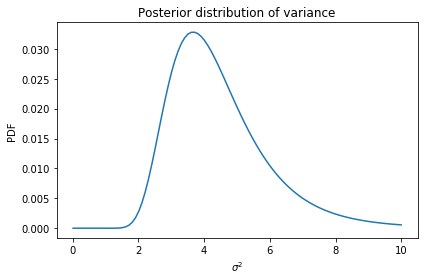

In [18]:
posterior_sigma2_invgammas.plot()
decorate(xlabel='$\sigma^2$',
         ylabel='PDF',
         title='Posterior distribution of variance')

In [19]:
sigmas = np.sqrt(sigma2s)
posterior_sigma_invgammas = Pmf(ps, sigmas)
posterior_sigma_invgammas.normalize()

9.92729006152895

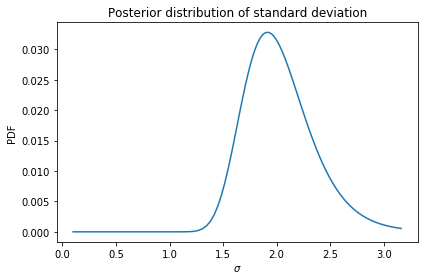

In [20]:
posterior_sigma_invgammas.plot()
decorate(xlabel='$\sigma$',
         ylabel='PDF',
         title='Posterior distribution of standard deviation')

In [21]:
posterior_sigma_invgammas.mean()

2.075829605223673

In [22]:
posterior_sigma_invgammas.std()

0.3290135633912751

In [23]:
2 / np.sqrt(2 * (n-1))

0.3244428422615251

## Posterior distribution of mu

In [24]:
from scipy.stats import t as student_t

def make_student_t(df, loc, scale):
    return student_t(df, loc=loc, scale=scale)

In [25]:
df = 2 * alpha_n
precision = alpha_n * kappa_n / beta_n
dist_mu = make_student_t(df, m_n, 1/np.sqrt(precision))

In [26]:
dist_mu.mean()

9.794416886805474

In [27]:
dist_mu.std()

0.473170236375643

In [28]:
np.sqrt(4/n)

0.4472135954999579

In [29]:
mus = np.linspace(8, 12, 101)
ps = dist_mu.pdf(mus)
posterior_mus = Pmf(ps, mus)

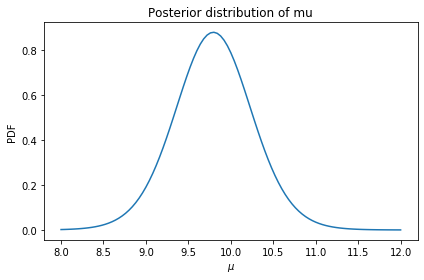

In [30]:
posterior_mus.plot()
decorate(xlabel='$\mu$',
         ylabel='PDF',
         title='Posterior distribution of mu')

In [31]:
def make_posterior_mu(m_n, kappa_n, alpha_n, beta_n):
    df = 2 * alpha_n
    loc = m_n
    precision = alpha_n * kappa_n / beta_n
    dist_mu = make_student_t(df, loc, 1/np.sqrt(precision))
    return dist_mu

## Posterior joint distribution

In [32]:
mu_mesh, sigma2_mesh = np.meshgrid(mus, sigma2s)

In [33]:
joint = (dist_sigma2.pdf(sigma2_mesh) * 
         norm(m_n, sigma2_mesh/kappa_n).pdf(mu_mesh))
joint_df = pd.DataFrame(joint, columns=mus, index=sigma2s)

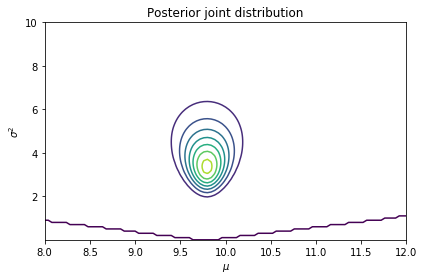

In [34]:
from utils import plot_contour

plot_contour(joint_df)
decorate(xlabel='$\mu$',
         ylabel='$\sigma^2$',
         title='Posterior joint distribution')

## Sampling from posterior predictive

In [35]:
sample_sigma2 = dist_sigma2.rvs(1000)

In [36]:
sample_mu = norm(m_n, sample_sigma2 / kappa_n).rvs()

In [37]:
sample_pred = norm(sample_mu, np.sqrt(sample_sigma2)).rvs()

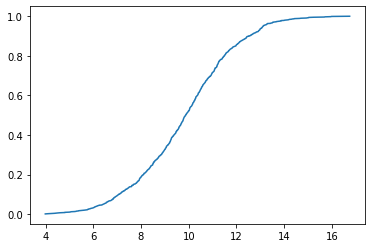

In [38]:
cdf_pred = Cdf.from_seq(sample_pred)
cdf_pred.plot()

In [39]:
sample_pred.mean(), sample_pred.var()

(9.84456832083291, 4.230082256705911)

## Analytic posterior predictive

In [40]:
df = 2 * alpha_n
precision = alpha_n * kappa_n / beta_n / (kappa_n+1)
dist_pred = make_student_t(df, m_n, 1/np.sqrt(precision))

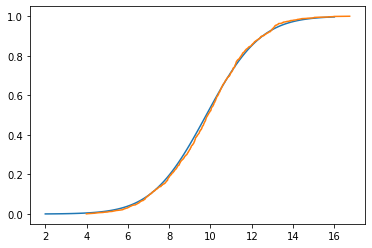

In [41]:
xs = np.linspace(2, 16, 101)
ys = dist_pred.cdf(xs)

plt.plot(xs, ys)
cdf_pred.plot()

In [42]:
def make_posterior_pred(m_n, kappa_n, alpha_n, beta_n):
    df = 2 * alpha_n
    loc = m_n
    precision = alpha_n * kappa_n / beta_n / (kappa_n+1)
    dist_pred = make_student_t(df, loc, 1/np.sqrt(precision))
    return dist_pred

## Multivariate normal

## Generate data

In [43]:
mean = [10, 20]

sigma_x = 2
sigma_y = 3
rho = 0.3
cov = rho * sigma_x * sigma_y 

Sigma = [[sigma_x**2, cov], [cov, sigma_y**2]]
Sigma

[[4, 1.7999999999999998], [1.7999999999999998, 9]]

In [44]:
from scipy.stats import multivariate_normal

n = 20
data = multivariate_normal(mean, Sigma).rvs(n)
data

array([[10.44379324, 18.3936843 ],
       [12.46765693, 24.0073328 ],
       [10.81773962, 26.6432393 ],
       [ 9.88116995, 23.48407239],
       [ 7.28394576, 20.28871105],
       [10.54981738, 22.48000387],
       [10.11096506, 21.01647928],
       [10.57847921, 17.93052365],
       [ 8.7990355 , 23.77974948],
       [ 9.8126    , 16.71896621],
       [ 9.84417254, 27.65704909],
       [ 9.61736078, 23.00607793],
       [12.67907171, 18.10948836],
       [ 9.07724123, 16.74282185],
       [13.33598448, 19.15063024],
       [ 8.96145849, 16.60850199],
       [ 6.83919386, 16.64095496],
       [12.75275435, 20.30766967],
       [ 8.51229891, 16.96243728],
       [ 8.48844595, 22.59190521]])

In [45]:
n = len(data)
n

20

In [46]:
xbar = np.mean(data, axis=0)
xbar

array([10.04265925, 20.62601495])

In [47]:
S = np.cov(data.transpose())
S

array([[ 3.10051096,  0.92537999],
       [ 0.92537999, 11.84580665]])

In [48]:
np.corrcoef(data.transpose())

array([[1.        , 0.15269371],
       [0.15269371, 1.        ]])

In [49]:
stds = np.sqrt(np.diag(S))
stds

array([1.76082678, 3.44177376])

In [50]:
corrcoef = S / np.outer(stds, stds)
corrcoef

array([[1.        , 0.15269371],
       [0.15269371, 1.        ]])

In [51]:
def unpack_cov(S):
    stds = np.sqrt(np.diag(S))
    corrcoef = S / np.outer(stds, stds)
    return stds[0], stds[1], corrcoef[0][1]

In [52]:
sigma_x, sigma_y, rho = unpack_cov(S)
sigma_x, sigma_y, rho

(1.7608267831985442, 3.441773764993555, 0.15269370986993366)

In [53]:
def pack_cov(sigma_x, sigma_y, rho):
    cov = sigma_x * sigma_y * rho
    return np.array([[sigma_x**2, cov], [cov, sigma_y**2]])

In [54]:
pack_cov(sigma_x, sigma_y, rho)

array([[ 3.10051096,  0.92537999],
       [ 0.92537999, 11.84580665]])

In [55]:
S

array([[ 3.10051096,  0.92537999],
       [ 0.92537999, 11.84580665]])

## Update



In [56]:
m0 = 0
Lambda0 = 0
nu0 = 0
kappa0 = 0

In [57]:
m_n = (kappa0 * m0 + n * xbar) / (kappa0 + n)
m_n

array([10.04265925, 20.62601495])

In [58]:
xbar

array([10.04265925, 20.62601495])

In [59]:
diff = (xbar - m0)
D = np.outer(diff, diff)
D

array([[100.85500477, 207.14003974],
       [207.14003974, 425.43249254]])

In [60]:
Lambda_n = Lambda0 + S + n * kappa0 * D / (kappa0 + n)
Lambda_n

array([[ 3.10051096,  0.92537999],
       [ 0.92537999, 11.84580665]])

In [61]:
S

array([[ 3.10051096,  0.92537999],
       [ 0.92537999, 11.84580665]])

In [62]:
nu_n = nu0 + n
nu_n

20

In [63]:
kappa_n = kappa0 + n
kappa_n

20

## Posterior distribution of covariance

In [64]:
from scipy.stats import invwishart
from scipy.linalg import inv

def make_invwishart(nu, Lambda):
    d, _ = Lambda.shape
    return invwishart(nu, scale=Lambda * (nu - d - 1))

In [65]:
dist_cov = make_invwishart(nu_n, Lambda_n)

In [66]:
dist_cov.mean()

array([[ 3.10051096,  0.92537999],
       [ 0.92537999, 11.84580665]])

In [67]:
S

array([[ 3.10051096,  0.92537999],
       [ 0.92537999, 11.84580665]])

In [68]:
sample_Sigma = dist_cov.rvs(1000)
np.mean(sample_Sigma, axis=0)

array([[ 3.14589413,  0.97146615],
       [ 0.97146615, 11.82572304]])

In [69]:
res = [unpack_cov(Sigma) for Sigma in sample_Sigma]

In [70]:
sample_sigma_x, sample_sigma_y, sample_rho = np.transpose(res)
sample_sigma_x.mean(), sample_sigma_y.mean(), sample_rho.mean()

(1.7470201615886167, 3.3905250912403617, 0.15444815375613194)

In [71]:
unpack_cov(S)

(1.7608267831985442, 3.441773764993555, 0.15269370986993366)

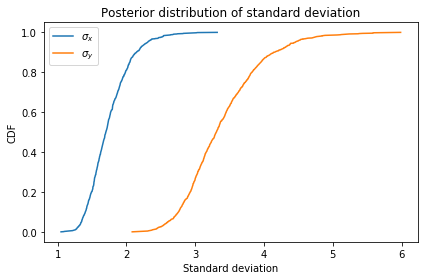

In [72]:
Cdf.from_seq(sample_sigma_x).plot(label='$\sigma_x$')
Cdf.from_seq(sample_sigma_y).plot(label='$\sigma_y$')

decorate(xlabel='Standard deviation',
         ylabel='CDF',
        title='Posterior distribution of standard deviation')

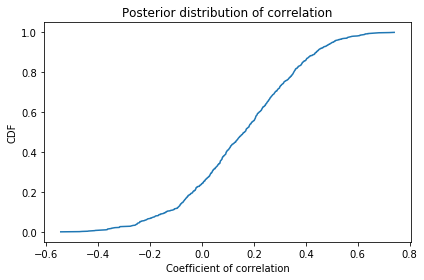

In [73]:
Cdf.from_seq(sample_rho).plot()

decorate(xlabel='Coefficient of correlation',
         ylabel='CDF',
         title='Posterior distribution of correlation')

## Evaluate the Inverse Wishart PDF

In [74]:
num = 51
sigma_xs = np.linspace(0.01, 10, num)

In [75]:
sigma_ys = np.linspace(0.01, 10, num)

In [76]:
rhos = np.linspace(-0.3, 0.6, num)

In [77]:
index = pd.MultiIndex.from_product([sigma_xs, sigma_ys, rhos],
                             names=['sigma_x', 'sigma_y', 'rho'])
joint = Pmf(0, index)
joint.head()

sigma_x  sigma_y  rho   
0.01     0.01     -0.300    0
                  -0.282    0
                  -0.264    0
                  -0.246    0
                  -0.228    0
dtype: int64

In [78]:
dist_cov.pdf(S)

0.00973403614090345

In [79]:
for sigma_x, sigma_y, rho in joint.index:
    Sigma = pack_cov(sigma_x, sigma_y, rho)
    joint.loc[sigma_x, sigma_y, rho] = dist_cov.pdf(Sigma)
    
joint.normalize()

11.675256915055522

In [80]:
from utils import pmf_marginal

posterior_sigma_grid_x = pmf_marginal(joint, 0)
posterior_sigma_grid_y = pmf_marginal(joint, 1)
marginal_rho = pmf_marginal(joint, 2)

posterior_sigma_grid_x.mean(), posterior_sigma_grid_y.mean(), marginal_rho.mean()

(1.6344548740552347, 3.194792556435294, 0.14279566459320348)

In [81]:
unpack_cov(S)

(1.7608267831985442, 3.441773764993555, 0.15269370986993366)

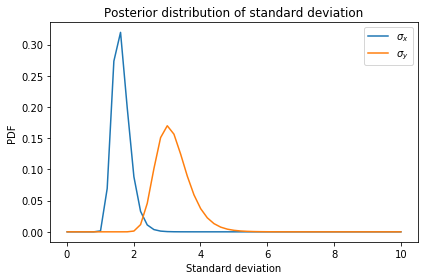

In [82]:
posterior_sigma_grid_x.plot(label='$\sigma_x$')
posterior_sigma_grid_y.plot(label='$\sigma_y$')

decorate(xlabel='Standard deviation',
         ylabel='PDF',
         title='Posterior distribution of standard deviation')

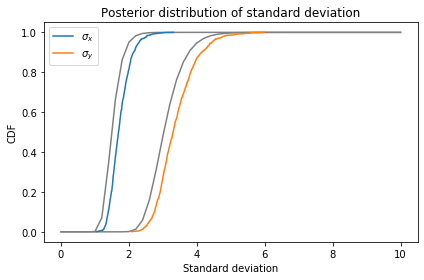

In [83]:
posterior_sigma_grid_x.make_cdf().plot(color='gray')
posterior_sigma_grid_y.make_cdf().plot(color='gray')

Cdf.from_seq(sample_sigma_x).plot(label='$\sigma_x$')
Cdf.from_seq(sample_sigma_y).plot(label='$\sigma_y$')

decorate(xlabel='Standard deviation',
         ylabel='CDF',
         title='Posterior distribution of standard deviation')

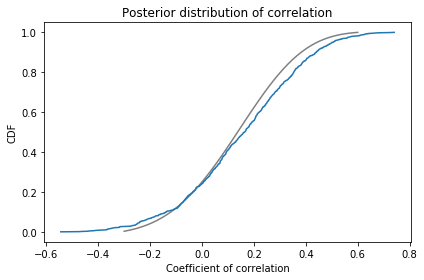

In [84]:
marginal_rho.make_cdf().plot(color='gray')

Cdf.from_seq(sample_rho).plot()

decorate(xlabel='Coefficient of correlation',
         ylabel='CDF',
         title='Posterior distribution of correlation')

## Posterior distribution of mu

In [85]:
sample_mu = [multivariate_normal(m_n, Sigma/kappa_n).rvs()
             for Sigma in sample_Sigma]

In [86]:
sample_mu0, sample_mu1 = np.transpose(sample_mu)

sample_mu0.mean(), sample_mu1.mean()

(10.050962657656278, 20.61466864209053)

In [87]:
xbar

array([10.04265925, 20.62601495])

In [88]:
sample_mu0.std(), sample_mu1.std()

(0.4004345350882152, 0.7782934609713221)

In [89]:
2 / np.sqrt(n), 3 / np.sqrt(n)

(0.4472135954999579, 0.6708203932499369)

In [90]:
prior = 0, 0, 0, 0
summary = n, xbar[0], S[0][0]
summary

(20, 10.042659247784052, 3.1005109604293333)

In [91]:
params = update_normal(prior, summary)
params

(10.042659247784052, 20, 10.0, 31.00510960429333)

In [92]:
dist_mu0 = make_posterior_mu(*params)
dist_mu0.mean(), dist_mu0.std()

(10.042659247784052, 0.41503085296486186)

In [93]:
mu0s = np.linspace(8, 12, 101)
ps = dist_mu0.pdf(mu0s)
posterior_mu0 = Pmf(ps, index=mu0s)
posterior_mu0.normalize()

24.998688787028048

In [94]:
prior = 0, 0, 0, 0
summary = n, xbar[1], S[1][1]
summary

(20, 20.62601494567528, 11.845806649397911)

In [95]:
params = update_normal(prior, summary)
params

(20.62601494567528, 20, 10.0, 118.45806649397912)

In [96]:
dist_mu1 = make_posterior_mu(*params)
dist_mu1.mean(), dist_mu1.std()

(20.62601494567528, 0.8112338561789658)

In [97]:
mu1s = np.linspace(18, 22, 101)
ps = dist_mu1.pdf(mu1s)
posterior_mu1 = Pmf(ps, index=mu1s)
posterior_mu1.normalize()

23.90360329619719

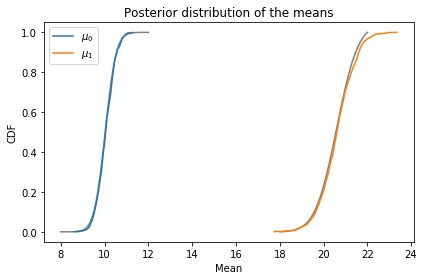

In [98]:
posterior_mu0.make_cdf().plot(color='gray')
posterior_mu1.make_cdf().plot(color='gray')

Cdf.from_seq(sample_mu0).plot(label='$\mu_0$')
Cdf.from_seq(sample_mu1).plot(label='$\mu_1$')

decorate(xlabel='Mean',
         ylabel='CDF',
         title='Posterior distribution of the means')

## Sampling from posterior predictive

In [99]:
sample_pred = [multivariate_normal(mu, Sigma).rvs()
               for mu, Sigma in zip(sample_mu, sample_Sigma)]

In [100]:
sample_x0, sample_x1 = np.transpose(sample_pred)

sample_x0.mean(), sample_x1.mean()

(10.078813858023606, 20.683585838686874)

In [101]:
sample_x0.std(), sample_x1.std()

(1.869261671509512, 3.559491544544339)

In [102]:
prior = 0, 0, 0, 0
summary = n, xbar[0], S[0][0]
params = update_normal(prior, summary)
dist_x0 = make_posterior_pred(*params)
dist_x0.mean(), dist_x0.std()

(10.042659247784052, 1.9019102994535666)

In [103]:
x0s = np.linspace(2, 18, 101)
ps = dist_x0.pdf(x0s)
posterior_x0 = Pmf(ps, index=x0s)
posterior_x0.normalize()

6.2485616912408295

In [104]:
prior = 0, 0, 0, 0
summary = n, xbar[1], S[1][1]
params = update_normal(prior, summary)
dist_x1 = make_posterior_pred(*params)
dist_x1.mean(), dist_x1.std()

(20.62601494567528, 3.717540552251031)

In [105]:
x1s = np.linspace(10, 30, 101)
ps = dist_x1.pdf(x1s)
posterior_x1 = Pmf(ps, index=x1s)
posterior_x1.normalize()

4.9484239091321935

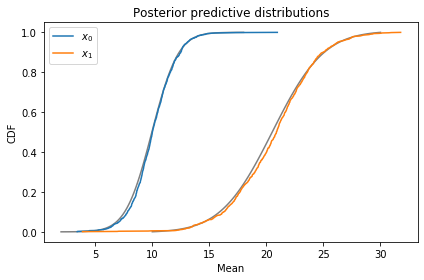

In [106]:
posterior_x0.make_cdf().plot(color='gray')
posterior_x1.make_cdf().plot(color='gray')

Cdf.from_seq(sample_x0).plot(label='$x_0$')
Cdf.from_seq(sample_x1).plot(label='$x_1$')

decorate(xlabel='Mean',
         ylabel='CDF',
         title='Posterior predictive distributions')

## Bayesian linear regression

## Generate data

In [107]:
inter, slope = 5, 2
sigma = 3
n = 20

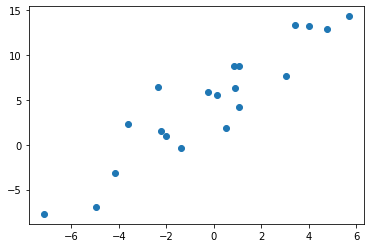

In [108]:
xs = norm(0, 3).rvs(n)
xs = np.sort(xs)
ys = inter + slope * xs + norm(0, sigma).rvs(20)

plt.plot(xs, ys, 'o');

In [109]:
import statsmodels.api as sm

X = sm.add_constant(xs)
X

array([[ 1.        , -7.14081558],
       [ 1.        , -4.97056864],
       [ 1.        , -4.14511327],
       [ 1.        , -3.60699454],
       [ 1.        , -2.34504973],
       [ 1.        , -2.23070091],
       [ 1.        , -2.01663514],
       [ 1.        , -1.39495617],
       [ 1.        , -0.25815572],
       [ 1.        ,  0.13044382],
       [ 1.        ,  0.50277724],
       [ 1.        ,  0.86162368],
       [ 1.        ,  0.88841408],
       [ 1.        ,  1.0586777 ],
       [ 1.        ,  1.06836983],
       [ 1.        ,  3.02709536],
       [ 1.        ,  3.44367206],
       [ 1.        ,  4.03238237],
       [ 1.        ,  4.76233222],
       [ 1.        ,  5.68179196]])

In [110]:
model = sm.OLS(ys, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     106.2
Date:                Fri, 02 Oct 2020   Prob (F-statistic):           5.61e-09
Time:                        11:57:54   Log-Likelihood:                -45.605
No. Observations:                  20   AIC:                             95.21
Df Residuals:                      18   BIC:                             97.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0348      0.558      9.020      0.000       3.862       6.208
x1             1.7393      0.169     10.305      0.000       1.385       2.094
==============================================================================
Omnibus:                        0.428   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.362
Skew:                           0.284   Prob(JB):                        0.834
Kurtosis:                       2.666   Cond. No.                         3.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
beta_hat = results.params
beta_hat

array([5.03484071, 1.73925656])

In [112]:
# k = results.df_model
k = 2

In [113]:
s2 = results.resid @ results.resid / (n - k)
s2

6.22108448995537

In [114]:
s2 = results.ssr / (n - k)
s2

6.22108448995537

In [115]:
np.sqrt(s2)

2.494210193619489

## Grid algorithm

In [116]:
beta0s = np.linspace(2, 8, 71)
prior_inter = Pmf(1, beta0s, name='inter')
prior_inter.index.name = 'Intercept'

In [117]:
beta1s = np.linspace(1, 3, 61)
prior_slope = Pmf(1, beta1s, name='slope')
prior_slope.index.name = 'Slope'

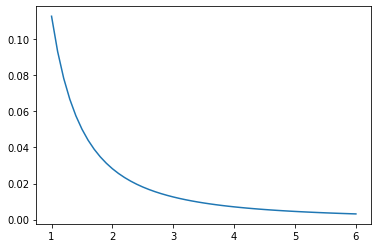

In [118]:
sigmas = np.linspace(1, 6, 51)
ps = sigmas**-2
prior_sigma = Pmf(ps, sigmas, name='sigma')
prior_sigma.index.name = 'Sigma'
prior_sigma.normalize()

prior_sigma.plot()

In [119]:
from utils import make_joint

def make_joint3(pmf1, pmf2, pmf3):
    """Make a joint distribution with three parameters.
    
    pmf1: Pmf object
    pmf2: Pmf object
    pmf3: Pmf object
    
    returns: Pmf representing a joint distribution
    """
    joint2 = make_joint(pmf2, pmf1).stack()
    joint3 = make_joint(pmf3, joint2).stack()
    return Pmf(joint3)

In [120]:
prior3 = make_joint3(prior_slope, prior_inter, prior_sigma)
prior3.head()

Slope  Intercept  Sigma
1.0    2.0        1.0      0.112819
                  1.1      0.093239
                  1.2      0.078346
                  1.3      0.066757
                  1.4      0.057561
dtype: float64

In [121]:
from utils import normalize

def update_optimized(prior, data):
    """Posterior distribution of regression parameters
    `slope`, `inter`, and `sigma`.
    
    prior: Pmf representing the joint prior
    data: DataFrame with columns `x` and `y`
    
    returns: Pmf representing the joint posterior
    """
    xs = data['x']
    ys = data['y']
    sigmas = prior.columns
    likelihood = prior.copy()

    for slope, inter in prior.index:
        expected = slope * xs + inter
        resid = ys - expected
        resid_mesh, sigma_mesh = np.meshgrid(resid, sigmas)
        densities = norm.pdf(resid_mesh, 0, sigma_mesh)
        likelihood.loc[slope, inter] = densities.prod(axis=1)
        
    posterior = prior * likelihood
    normalize(posterior)
    return posterior

In [122]:
data = pd.DataFrame(dict(x=xs, y=ys))

In [123]:
from utils import normalize

posterior = update_optimized(prior3.unstack(), data)
normalize(posterior)

1.0000000000000007

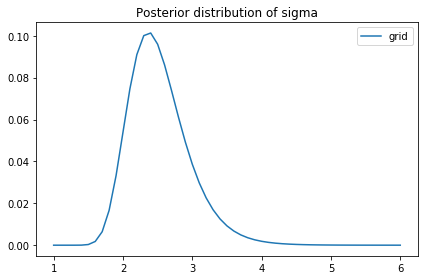

In [124]:
from utils import marginal

posterior_sigma_grid = marginal(posterior, 0)
posterior_sigma_grid.plot(label='grid')

decorate(title='Posterior distribution of sigma')

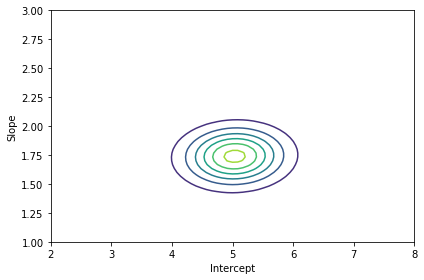

In [125]:
joint_posterior = marginal(posterior, 1).unstack()
plot_contour(joint_posterior)

In [126]:
posterior_beta0_grid = marginal(joint_posterior, 0)
posterior_beta1_grid = marginal(joint_posterior, 1)

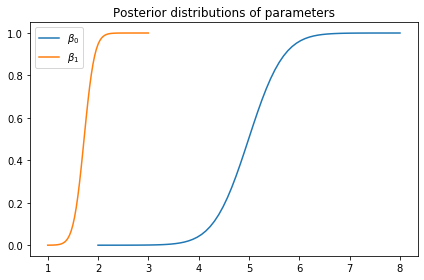

In [127]:
posterior_beta0_grid.make_cdf().plot(label=r'$\beta_0$')
posterior_beta1_grid.make_cdf().plot(label=r'$\beta_1$')

decorate(title='Posterior distributions of parameters')

## Posterior distribution of sigma

According to Gelman et al, the posterior distribution of $\sigma^2$ is scaled inverse chi2 with $\nu=n-k$ and scale $s^2$.

According to [Wikipedia](https://en.wikipedia.org/wiki/Scaled_inverse_chi-squared_distribution), that's equivalent to inverse gamma with parameters $\nu/2$ and $\nu s^2 / 2$.

In [128]:
nu = n-k
nu/2, nu*s2/2

(9.0, 55.98976040959833)

In [129]:
from scipy.stats import invgamma

dist_sigma2 = invgamma(nu/2, scale=nu*s2/2)
dist_sigma2.mean()

6.998720051199792

In [130]:
sigma2s = np.linspace(0.01, 30, 101)
ps = dist_sigma2.pdf(sigma2s)
posterior_sigma2_invgamma = Pmf(ps, sigma2s)
posterior_sigma2_invgamma.normalize()

3.3339841667914865

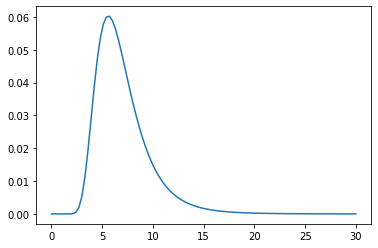

In [131]:
posterior_sigma2_invgamma.plot()

In [132]:
sigmas = np.sqrt(sigma2s)
posterior_sigma_invgamma = Pmf(ps, sigmas)
posterior_sigma_invgamma.normalize()

3.3339841667914865

In [133]:
posterior_sigma_invgamma.mean(), posterior_sigma_grid.mean()

(2.6040683822952175, 2.5288743440109838)

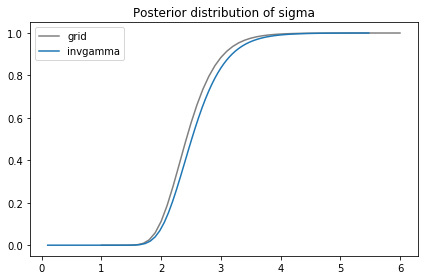

In [134]:
posterior_sigma_grid.make_cdf().plot(color='gray', label='grid')
posterior_sigma_invgamma.make_cdf().plot(label='invgamma')

decorate(title='Posterior distribution of sigma')

## Posterior distribution of sigma, updatable version

Per the Wikipedia page: https://en.wikipedia.org/wiki/Bayesian_linear_regression

In [135]:
Lambda_0 = np.zeros((k, k))
Lambda_n = Lambda_0 + X.T @ X
Lambda_n

array([[ 20.        ,  -2.65140939],
       [ -2.65140939, 218.75336987]])

In [136]:
mu_0 = np.zeros(k)
mu_n = inv(Lambda_n) @ (Lambda_0 @ mu_0 + X.T @ X @ beta_hat)
mu_n

array([5.03484071, 1.73925656])

In [137]:
a_0 = 0
a_n = a_0 + n / 2
a_n

10.0

In [138]:
b_0 = 0
b_n = b_0 + (ys.T @ ys + 
             mu_0.T @ Lambda_0 @ mu_0 - 
             mu_n.T @ Lambda_n @ mu_n) / 2
b_n

55.9897604095986

In [139]:
a_n, nu/2

(10.0, 9.0)

In [140]:
b_n, nu * s2 / 2

(55.9897604095986, 55.98976040959833)

## Sampling the posterior of the parameters

In [141]:
sample_sigma2 = dist_sigma2.rvs(1000)

In [142]:
sample_sigma = np.sqrt(sample_sigma2)

In [143]:
from scipy.linalg import inv

V_beta = inv(X.T @ X)
V_beta

array([[0.05008047, 0.000607  ],
       [0.000607  , 0.00457872]])

In [144]:
sample_beta = [multivariate_normal(beta_hat, V_beta * sigma2).rvs()
               for sigma2 in sample_sigma2]

In [145]:
np.mean(sample_beta, axis=0)

array([5.04511233, 1.74339804])

In [146]:
beta_hat

array([5.03484071, 1.73925656])

In [147]:
np.std(sample_beta, axis=0)

array([0.58586532, 0.17427858])

In [148]:
results.bse

array([0.55817098, 0.16877374])

In [149]:
sample_beta0, sample_beta1 = np.transpose(sample_beta)

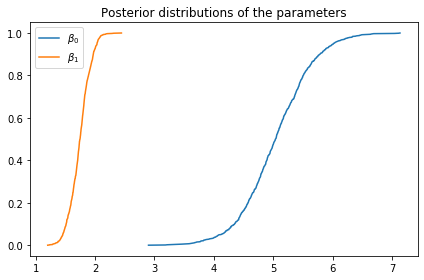

In [150]:
Cdf.from_seq(sample_beta0).plot(label=r'$\beta_0$')
Cdf.from_seq(sample_beta1).plot(label=r'$\beta_1$')

decorate(title='Posterior distributions of the parameters')

## Multivariate student t

Let's use [this implementation](http://gregorygundersen.com/blog/2020/01/20/multivariate-t/)

In [151]:
from scipy.special import gammaln

def multistudent_pdf(x, mean, shape, df):
    return np.exp(logpdf(x, mean, shape, df))

def logpdf(x, mean, shape, df):
    # TODO: send the suggestion to use `mean`
    # rather than `x` to determine p
    p = len(mean)

    vals, vecs = np.linalg.eigh(shape)
    logdet     = np.log(vals).sum()
    valsinv    = np.array([1.0/v for v in vals])
    U          = vecs * np.sqrt(valsinv)
    dev        = x - mean
    maha       = np.square(dev @ U).sum(axis=-1)

    t = 0.5 * (df + p)
    A = gammaln(t)
    B = gammaln(0.5 * df)
    C = p/2. * np.log(df * np.pi)
    D = 0.5 * logdet
    E = -t * np.log(1 + (1./df) * maha)

    return A - B - C - D + E

In [152]:
x = beta_hat
mean = beta_hat
df = (n - k)
shape = (V_beta * s2)
multistudent_pdf(x, mean, shape, df)

1.690819342500572

In [153]:
low, high = sample_beta0.min(), sample_beta0.max()
low, high

(2.899370980902629, 7.132304794886583)

In [154]:
beta0s = np.linspace(0.9*low, 1.1*high, 101)

In [155]:
low, high = sample_beta1.min(), sample_beta1.max()

In [156]:
beta1s = np.linspace(0.9*low, 1.1*high, 91)

In [157]:
beta0_mesh, beta1_mesh = np.meshgrid(beta0s, beta1s)

In [158]:
beta_mesh = np.dstack(np.meshgrid(beta0s, beta1s))
beta_mesh.shape

(91, 101, 2)

In [159]:
ps = multistudent_pdf(beta_mesh, mean, shape, df)
ps.shape

(91, 101)

In [160]:
joint = pd.DataFrame(ps, columns=beta0s, index=beta1s)

In [161]:
from utils import normalize

normalize(joint)

1069.6943385401676

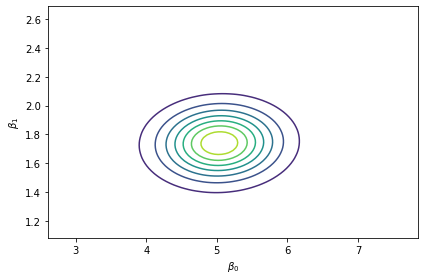

In [162]:
from utils import plot_contour

plot_contour(joint)
decorate(xlabel=r'$\beta_0$',
         ylabel=r'$\beta_1$')

In [163]:
marginal_beta0_student = marginal(joint, 0)
marginal_beta1_student = marginal(joint, 1)

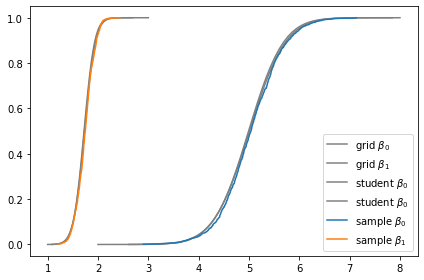

In [164]:
from utils import marginal

posterior_beta0_grid.make_cdf().plot(color='gray', label=r'grid $\beta_0$')
posterior_beta1_grid.make_cdf().plot(color='gray', label=r'grid $\beta_1$')

marginal_beta0_student.make_cdf().plot(label=r'student $\beta_0$', color='gray')
marginal_beta1_student.make_cdf().plot(label=r'student $\beta_0$', color='gray')

Cdf.from_seq(sample_beta0).plot(label=r'sample $\beta_0$')
Cdf.from_seq(sample_beta1).plot(label=r'sample $\beta_1$')

decorate()

## Sampling the predictive distribution

In [165]:
t = [X @ beta + norm(0, sigma).rvs(n)
     for beta, sigma in zip(sample_beta, sample_sigma)]
predictions = np.array(t)
predictions.shape

(1000, 20)

In [166]:
low, median, high = np.percentile(predictions, [5, 50, 95], axis=0)

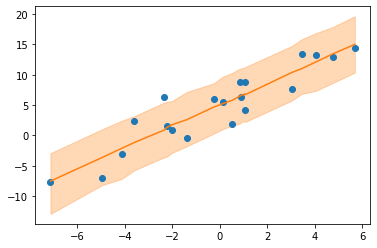

In [167]:
plt.plot(xs, ys, 'o')
plt.plot(xs, median)
plt.fill_between(xs, low, high, color='C1', alpha=0.3)

## Modeling the predictive distribution

In [172]:
xnew = [1, 2, 3]
Xnew = sm.add_constant(xnew)
Xnew

array([[1., 1.],
       [1., 2.],
       [1., 3.]])

In [183]:
t = [Xnew @ beta + norm(0, sigma).rvs(len(xnew))
     for beta, sigma in zip(sample_beta, sample_sigma)]
predictions = np.array(t)
predictions.shape

(1000, 3)

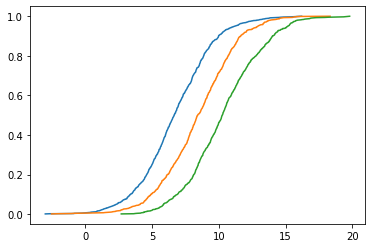

In [186]:
x0, x1, x2 = predictions.T

Cdf.from_seq(x0).plot()
Cdf.from_seq(x1).plot()
Cdf.from_seq(x2).plot()

In [173]:
mu_new = Xnew @ beta_hat
mu_new

array([ 6.77409728,  8.51335384, 10.2526104 ])

In [180]:
cov_new = s2 * (np.eye(len(xnew)) + Xnew @ V_beta @ Xnew.T)
cov_new

array([[6.56867633, 0.37985263, 0.41211342],
       [0.37985263, 6.66168248, 0.50134336],
       [0.41211342, 0.50134336, 6.81165779]])

In [181]:
x = mu_new
mean = mu_new
df = (n - k)
shape = cov_new
multistudent_pdf(x, mean, shape, df)

0.0038518551666337944

In [200]:
y1s = np.linspace(0, 20, 51)
y0s = np.linspace(0, 20, 61)
y2s = np.linspace(0, 20, 71)

In [201]:
mesh = np.stack(np.meshgrid(y0s, y1s, y2s), axis=-1)
mesh.shape

(51, 61, 71, 3)

In [202]:
ps = multistudent_pdf(mesh, mean, shape, df)
ps.shape

(51, 61, 71)

In [220]:
ps /= ps.sum()
ps.sum()

1.0000000000000004

In [221]:
p1s = ps.sum(axis=1).sum(axis=1)
p1s.shape

(51,)

In [222]:
p0s = ps.sum(axis=0).sum(axis=1)
p0s.shape

(61,)

In [223]:
p2s = ps.sum(axis=0).sum(axis=0)
p2s.shape

(71,)

In [225]:
pmf_y0 = Pmf(p0s, y0s)
pmf_y1 = Pmf(p1s, y1s)
pmf_y2 = Pmf(p2s, y2s)

pmf_y0.mean(), pmf_y1.mean(), pmf_y2.mean()

(6.832437207246759, 8.53089151948943, 10.254817832677237)

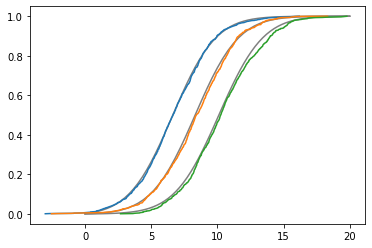

In [229]:
pmf_y0.make_cdf().plot(color='gray')
pmf_y1.make_cdf().plot(color='gray')
pmf_y2.make_cdf().plot(color='gray')

Cdf.from_seq(x0).plot()
Cdf.from_seq(x1).plot()
Cdf.from_seq(x2).plot()

In [168]:
stop

NameError: name 'stop' is not defined

## Leftovers

Related discussion saved for the future

https://stats.stackexchange.com/questions/78177/posterior-covariance-of-normal-inverse-wishart-not-converging-properly

In [ ]:
from scipy.stats import chi2


class NormalInverseWishartDistribution(object):
    def __init__(self, mu, lmbda, nu, psi):
        self.mu = mu
        self.lmbda = float(lmbda)
        self.nu = nu
        self.psi = psi
        self.inv_psi = np.linalg.inv(psi)

    def sample(self):
        sigma = np.linalg.inv(self.wishartrand())
        return (np.random.multivariate_normal(self.mu, sigma / self.lmbda), sigma)

    def wishartrand(self):
        dim = self.inv_psi.shape[0]
        chol = np.linalg.cholesky(self.inv_psi)
        foo = np.zeros((dim,dim))

        for i in range(dim):
            for j in range(i+1):
                if i == j:
                    foo[i,j] = np.sqrt(chi2.rvs(self.nu-(i+1)+1))
                else:
                    foo[i,j]  = np.random.normal(0,1)
        return np.dot(chol, np.dot(foo, np.dot(foo.T, chol.T)))

    def posterior(self, data):
        n = len(data)
        mean_data = np.mean(data, axis=0)
        sum_squares = np.sum([np.array(np.matrix(x - mean_data).T * np.matrix(x - mean_data)) for x in data], axis=0)
        mu_n = (self.lmbda * self.mu + n * mean_data) / (self.lmbda + n)
        lmbda_n = self.lmbda + n
        nu_n = self.nu + n
        dev = mean_data - self.mu
        psi_n = (self.psi + sum_squares + 
                 self.lmbda * n / (self.lmbda + n) * np.array(dev.T @ dev))
        return NormalInverseWishartDistribution(mu_n, lmbda_n, nu_n, psi_n)

    

x = NormalInverseWishartDistribution(np.array([0,0])-3,1,3,np.eye(2))
samples = [x.sample() for _ in range(100)]
data = [np.random.multivariate_normal(mu,cov) for mu,cov in samples]
y = NormalInverseWishartDistribution(np.array([0,0]),1,3,np.eye(2))
z = y.posterior(data)

print('mu_n: {0}'.format(z.mu))

print('psi_n: {0}'.format(z.psi))

In [ ]:
from scipy.linalg import inv
from scipy.linalg import cholesky

def wishartrand(nu, Lambda):
    d, _ = Lambda.shape
    chol = cholesky(Lambda)
    foo = np.empty((d, d))

    for i in range(d):
        for j in range(i+1):
            if i == j:
                foo[i,j] = np.sqrt(chi2.rvs(nu-(i+1)+1))
            else:
                foo[i,j] = np.random.normal(0, 1)
                
    return np.dot(chol, np.dot(foo, np.dot(foo.T, chol.T)))

In [ ]:
sample = [wishartrand(nu_n, Lambda_n) for i in range(1000)]

In [ ]:
np.mean(sample, axis=0)

In [ ]:
Lambda_n